In [ ]:
import datetime
import os
import json
from datetime import timezone, date, timedelta
import base64
import operator
from typing import TypedDict, Annotated, List, Optional, Literal


from dotenv import load_dotenv
from pydantic import BaseModel, Field
from tzlocal import get_localzone
import parsedatetime as pdt
from dateutil.parser import parse, ParserError


from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError


from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage
from langchain_groq import ChatGroq
from langchain_tavily import TavilySearch
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.sqlite import SqliteSaver


from IPython.display import Image, display


In [ ]:
load_dotenv()

groq_api_key = os.getenv("GROQ_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY") 

SCOPES = ["https://www.googleapis.com/auth/calendar", "https://www.googleapis.com/auth/gmail.modify"]

if not all([groq_api_key, tavily_api_key]):
    raise ValueError("One or more required API keys (GROQ, TAVILY) are missing from the .env file!")


# For high-quality, reliable, and rule-following responses (the 70b model).
# Use this for testing complex workflows. 
llm = ChatGroq(model="llama-3.3-70b-versatile", api_key=groq_api_key, temperature=0)

# For rapid development and simple tests (the 8b model).
# Note: This model is much faster but may not follow complex instructions as precisely.
#llm = ChatGroq(model="llama-3.1-8b-instant", api_key=groq_api_key, temperature=0)


print("Groq LLM (Llama) configured and ready.")

In [ ]:
def _get_google_credentials():
    """Gets valid Google API credentials, refreshing if necessary."""

    creds = None

    if os.path.exists("token.json"):
        creds = Credentials.from_authorized_user_file("token.json", SCOPES)

    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file("credentials.json", SCOPES)
            creds = flow.run_local_server(port=0)
        with open("token.json", "w") as token:
            token.write(creds.to_json())

    return creds


def _fetch_google_events(start_date: datetime.datetime, end_date: datetime.datetime) -> List[dict]:
    """Internal function to fetch events from Google Calendar."""

    try:
        creds = _get_google_credentials()
        service = build("calendar", "v3", credentials=creds)
        
        events_result = service.events().list(
            calendarId="primary",
            timeMin=start_date.isoformat(),
            timeMax=end_date.isoformat(),
            maxResults=250,
            singleEvents=True,
            orderBy="startTime"
        ).execute()
        
        return events_result.get("items", [])

    except HttpError as error:
        print(f"!!! Google Calendar API Error: {error}")
        return [{"error": f"An API error occurred: {error}"}]

    except Exception as e:
        print(f"!!! An unexpected error occurred: {e}")
        return [{"error": f"An unexpected error occurred: {e}"}]


def _get_email_body(parts):
    """Recursively search for text/plain parts in email body."""

    body = ""
    if parts:
        for part in parts:
            if part['mimeType'] == 'text/plain' and 'data' in part['body']:
                body += base64.urlsafe_b64decode(part['body']['data']).decode('utf-8')
            elif 'parts' in part:
                body += _get_email_body(part['parts'])

    return body


def _fetch_gmail_messages(query: str, max_results: int = 10) -> List[dict]:
    """Internal function to fetch and sort emails from Gmail using batch processing."""
    
    try:
        creds = _get_google_credentials()
        service = build("gmail", "v1", credentials=creds)

        message_list = service.users().messages().list(userId='me', q=query, maxResults=max_results).execute()
        messages = message_list.get('messages', [])
        
        if not messages: return []

        output_emails = []

        def gmail_callback(request_id, response, exception):
            if exception is None:
                headers = response['payload']['headers']
                output_emails.append({
                    "id": response['id'],
                    "sender": next((h['value'] for h in headers if h['name'] == 'From'), 'Unknown Sender'),
                    "subject": next((h['value'] for h in headers if h['name'] == 'Subject'), 'No Subject'),
                    "date": next((h['value'] for h in headers if h['name'] == 'Date'), 'Unknown Date'),
                    "body": _get_email_body(response['payload'].get('parts', []))[:2000],
                    "internalDate": response['internalDate']
                })

        batch_request = service.new_batch_http_request(callback=gmail_callback)
        for msg in messages:
            batch_request.add(service.users().messages().get(userId='me', id=msg['id'], format='full'))
        
        batch_request.execute()
        output_emails.sort(key=lambda e: int(e['internalDate']), reverse=True)
        return output_emails

    except HttpError as error:
        print(f"!!! Gmail API Error: {error}")
        return [{"error": f"An error occurred with the Gmail API: {error}"}]

    except Exception as e:
        print(f"!!! An unexpected error occurred: {e}")
        return [{"error": f"An unexpected error occurred: {e}"}]



In [ ]:
def _parse_natural_language_time(natural_language_time: str) -> datetime.datetime | None:
    """
    Parses a natural language date and time string into a timezone-aware datetime object.
    This is our single, robust helper for all date/time parsing needs.
    """

    try:
        cal = pdt.Calendar()
        time_struct, parse_status = cal.parse(natural_language_time)

        if parse_status != 0:
            dt_object = datetime.datetime(*time_struct[:6])

            return dt_object.replace(tzinfo=get_localzone())
        return None

    except Exception:
        return None


In [ ]:
@tool
def list_upcoming_events(limit: Optional[int] = 15) -> str:
    """Lists the user's upcoming Google Calendar events from today onwards."""

    print(f"--- Tool: list_upcoming_events called with limit={limit} ---")

    now = datetime.datetime.now(timezone.utc)
    search_end = now + datetime.timedelta(days=90)

    google_events = _fetch_google_events(start_date=now, end_date=search_end)

    if not google_events or all('error' in e for e in google_events):
        return json.dumps([{"message": "No upcoming events found."}])

    valid_events = [e for e in google_events if 'error' not in e]

    return json.dumps(valid_events[:limit], indent=2)


@tool
def get_events_for_day(natural_language_date: str) -> str:
    """Finds and lists all Google Calendar events for a specific day (like 'tomorrow', 'this Sunday')."""

    dt_obj = _parse_natural_language_time(natural_language_date)

    if not dt_obj:
        return json.dumps([{"error": f"I could not understand the date: '{natural_language_date}'"}])

    target_date = dt_obj.date()
    
    print(f"--- Tool: get_events_for_day called for '{natural_language_date}' -> Resolved to: {target_date.isoformat()} ---")

    try:
        start_of_day = datetime.datetime.combine(target_date, datetime.time.min).replace(tzinfo=get_localzone())
        end_of_day = datetime.datetime.combine(target_date, datetime.time.max).replace(tzinfo=get_localzone())

        google_events = _fetch_google_events(start_date=start_of_day.astimezone(timezone.utc), end_date=end_of_day.astimezone(timezone.utc))
        valid_events = [e for e in google_events if 'error' not in e]

        if not valid_events:
            return json.dumps([])
        return json.dumps(valid_events, indent=2)

    except Exception as e:
        return json.dumps([{"error": f"An unexpected error occurred: {e}"}])

@tool
def tavily_search(query: str) -> str:
    """A search engine tool to find real-time information online."""

    print(f"--- Tool: tavily_search called with query: '{query}' ---")

    try:
        search = TavilySearch(max_results=3, api_key=tavily_api_key)
        results = search.invoke(query)
        return json.dumps(results, indent=2)

    except Exception as e:
        return f"Error occurred during web search: {e}"


@tool
def create_google_event(
    summary: str, 
    start_time_natural: str, 
    duration_minutes: int,
    description: Optional[str] = None, 
    location: Optional[str] = None, 
    attendees: Optional[List[str]] = None
) -> str:
    """
    Creates a new event on Google Calendar using natural language for the start time after checking for conflicts.

    Args:
        summary (str): The title or summary of the event.
        start_time_natural (str): The start time in natural language (e.g., "tomorrow at 4 PM", "next Tuesday at 11am").
        duration_minutes (int): The duration of the event in minutes.
        description (Optional[str]): A detailed description for the event.
        location (Optional[str]): The physical location of the event.
        attendees (Optional[List[str]]): A list of attendee email addresses to invite.
    """

    print(f"--- Tool: create_google_event received natural language query: '{start_time_natural}' ---")

    start_time_obj = _parse_natural_language_time(start_time_natural)

    if not start_time_obj:
        return f"Error: I could not understand the start time '{start_time_natural}'."

    end_time_obj = start_time_obj + datetime.timedelta(minutes=duration_minutes)
    
    try:
        conflicting_events = _fetch_google_events(start_date=start_time_obj, end_date=end_time_obj)

        if conflicting_events:
            conflict_summary = conflicting_events[0].get('summary', 'an existing event')
            return f"Error: Cannot create event. There is a conflicting event at that time: '{conflict_summary}'."

        start_time_iso = start_time_obj.isoformat()
        end_time_iso = end_time_obj.isoformat()

        print(f"--- Finalizing API Call with: summary='{summary}', start='{start_time_iso}', end='{end_time_iso}', description='{description}', location='{location}', attendees='{attendees}' ---")

        creds = _get_google_credentials()
        service = build("calendar", "v3", credentials=creds)
        
        local_timezone = str(get_localzone())
        
        event_body = {
            'summary': summary,
            'start': {'dateTime': start_time_iso, 'timeZone': str(get_localzone())},
            'end': {'dateTime': end_time_iso, 'timeZone': str(get_localzone())},
        }

        if description:
            event_body['description'] = description
        
        if location:
            event_body['location'] = location
        
        if attendees:
            event_body['attendees'] = [{'email': email} for email in attendees]

        created_event = service.events().insert(calendarId='primary', body=event_body).execute()
        
        print(f"--- Success: Event created. ID: {created_event.get('id')} ---")
        return f"Success! Event '{summary}' was created for {start_time_obj.strftime('%Y-%m-%d %H:%M')}."

    except Exception as e:
        print(f"!!! Google Calendar Write Error: {e}")
        return f"An error occurred while creating the event in Google Calendar: {e}"



@tool
def delete_google_event(event_id: str, summary: str) -> str:
    """Deletes an event from the calendar using its unique ID."""

    print(f"--- Tool: delete_google_event called for ID: {event_id} ---")

    try:
        creds = _get_google_credentials()
        service = build("calendar", "v3", credentials=creds)
        service.events().delete(calendarId='primary', eventId=event_id).execute()

        return f"The event '{summary}' was successfully deleted."

    except Exception as e:
        return f"An error occurred while deleting the event: {e}"

@tool
def get_events_for_range(time_range: str) -> str:
    """
    Fetches all Google Calendar events for a specific range like "this week", "next week", or "this month".
    Use this for broader queries about a period of time, not a single day.
    Supported ranges: "this week", "next week", "this month".

    """
    print(f"--- Tool: get_events_for_range called for: {time_range} ---")

    today = datetime.date.today()
    start_date, end_date = None, None

    if time_range == "this week":
        start_date = today - datetime.timedelta(days=today.weekday())
        end_date = start_date + datetime.timedelta(days=6)
    elif time_range == "next week":
        start_date = today + datetime.timedelta(days=(7 - today.weekday()))
        end_date = start_date + datetime.timedelta(days=6)
    elif time_range == "this month":
        start_date = today.replace(day=1)
        next_month = start_date.replace(day=28) + datetime.timedelta(days=4)
        end_date = next_month - datetime.timedelta(days=next_month.day)
    else:
        return json.dumps([{"error": "Unsupported time range. Please use 'this week', 'next week', or 'this month'."}])

    print(f"--- Calculated Date Range: {start_date.isoformat()} to {end_date.isoformat()} ---")
    
    start_datetime = datetime.datetime.combine(start_date, datetime.time.min).astimezone(timezone.utc)
    end_datetime = datetime.datetime.combine(end_date, datetime.time.max).astimezone(timezone.utc)
    events = _fetch_google_events(start_date=start_datetime, end_date=end_datetime)

    return json.dumps(events, indent=2)

@tool
def update_google_event(
    event_id: str,
    new_summary: Optional[str] = None,
    new_start_time_natural: Optional[str] = None,
    new_duration_minutes: Optional[int] = None,
    new_description: Optional[str] = None,
    new_location: Optional[str] = None,
    new_attendees: Optional[List[str]] = None
    ) -> str:
    """
    Updates an existing Google Calendar event using its unique ID. 
    Accepts natural language for the new start time.
    If only a new start time is provided, the original duration is maintained
    """

    print(f"--- Tool: update_google_event called for ID: {event_id} ---")

    try:
        creds = _get_google_credentials()
        service = build("calendar", "v3", credentials=creds)

        event = service.events().get(calendarId='primary', eventId=event_id).execute()

        update_body = {}

        if new_summary:
            update_body['summary'] = new_summary

        if new_description:
            update_body['description'] = new_description
            
        if new_location:
            update_body['location'] = new_location
            
        if new_attendees is not None:
            update_body['attendees'] = [{'email': email} for email in new_attendees]

        if new_start_time_natural:
            new_start_obj = _parse_natural_language_time(new_start_time_natural)
            if not new_start_obj:
                return f"Error: I could not understand the new start time '{new_start_time_natural}'."
            
            if new_duration_minutes:
                new_end_obj = new_start_obj + datetime.timedelta(minutes=new_duration_minutes)
            else:
                original_start = parse(event['start'].get('dateTime'))
                original_end = parse(event['end'].get('dateTime'))
                original_duration = original_end - original_start
                new_end_obj = new_start_obj + original_duration

            update_body['start'] = {'dateTime': new_start_obj.isoformat(), 'timeZone': str(get_localzone())}
            update_body['end'] = {'dateTime': new_end_obj.isoformat(), 'timeZone': str(get_localzone())}
        
        if not update_body:
            return "Error: No update information was provided for the event."

        updated_event = service.events().patch(
            calendarId='primary', 
            eventId=event_id, 
            body=update_body
        ).execute()

        return f"Success! Event '{updated_event.get('summary')}' was updated."

    except HttpError as err:
        if err.resp.status == 404:
            return f"Error: The event with ID '{event_id}' was not found."
        return f"An API error occurred: {err}"
    except Exception as e:
        return f"An unexpected error occurred while updating the event: {e}"


In [ ]:

@tool
def search_emails(
    sender: Optional[str] = None, 
    subject: Optional[str] = None, 
    keywords: Optional[str] = None, 
    status: Optional[str] = "all", 
    time_range: Optional[str] = None, 
    max_results: int = 10
) -> str:
    """
    Searches for emails in the user's Gmail account based on various criteria.
    Returns the raw email data as a structured JSON string for the agent to process.
    """

    print(f"--- Tool: search_emails called with filters: status='{status}', sender='{sender}', subject='{subject}', keywords='{keywords}', time_range='{time_range}' ---")

    query_parts = []
    if status == "unread":
        query_parts.append("is:unread")
    elif status == "read":
        query_parts.append("is:read")
    if sender:
        query_parts.append(f"from:{sender}")
    if subject:
        query_parts.append(f"subject:({subject})")
    if keywords:
        query_parts.append(keywords)
    if time_range:
        query_parts.append(f"newer_than:{time_range}")

    query = " ".join(query_parts)

    emails = _fetch_gmail_messages(query=query, max_results=max_results)
    
    if not emails or all('error' in e for e in emails):
        return json.dumps([]) 

    return json.dumps(emails, indent=2)


@tool
def delete_email(message_id: str) -> str:
    """
    Moves a specific email to the trash using its unique message ID.
    To use this tool, you must first find the email and its 'id' using the `search_emails` tool.
    """
    print(f"--- Tool: delete_email called for message ID: {message_id} ---")
    try:
        creds = _get_google_credentials()
        service = build("gmail", "v1", credentials=creds)
        
        service.users().messages().trash(userId='me', id=message_id).execute()
        
        return "Success: The email was moved to the trash."
        
    except HttpError as error:
        if error.resp.status == 404:
            return f"Error: The email with ID '{message_id}' was not found."
        return f"An error occurred with the Gmail API: {error}"
    except Exception as e:
        return f"An unexpected error occurred while trying to delete the email: {e}"


@tool
def archive_email(message_id: str) -> str:
    """
    Archives a specific email by removing it from the inbox, using its unique message ID.
    To use this tool, you must first find the email and its 'id' using the `search_emails` tool.
    """
    print(f"--- Tool: archive_email called for message ID: {message_id} ---")
    try:
        creds = _get_google_credentials()
        service = build("gmail", "v1", credentials=creds)
        
        modify_request = {
            'removeLabelIds': ['INBOX']
        }
        
        service.users().messages().modify(
            userId='me', 
            id=message_id, 
            body=modify_request
        ).execute()
        
        return "Success: The email was archived and removed from the inbox."
        
    except HttpError as error:
        if error.resp.status == 404:
            return f"Error: The email with ID '{message_id}' was not found."
        return f"An error occurred with the Gmail API: {error}"
    except Exception as e:
        return f"An unexpected error occurred while trying to archive the email: {e}"

In [ ]:
calendar_tools = [
    list_upcoming_events,
    get_events_for_day,
    create_google_event,
    delete_google_event,
    get_events_for_range,
    update_google_event]

email_tools = [search_emails, delete_email, archive_email]

search_tools = [tavily_search]
    
print(f"Defined {len(calendar_tools)} tools for the Calendar Expert.")
print(f"Defined {len(email_tools)} tools for the Email Expert.")
print(f"Defined {len(search_tools)} tools for the Search Expert.")

In [ ]:
class AgentState(TypedDict):
    messages: Annotated[list, operator.add]
    route: Literal["calendar", "email", "search", "conversational"]
    error: str


class RouteQuery(BaseModel):
    """Route the user's query to the correct expert."""

    route: Literal["calendar", "email", "search", "conversational"] = Field(
        description="""The category to route the user's request to, based on their intent.
        - 'calendar': For listing, creating, deleting, updating events, or asking about the calendar.
        - 'email': For reading, searching, or summarizing emails.
        - 'search': For general knowledge, weather, news, or anything requiring a web search.
        - 'conversational': For greetings, thank yous, or simple chit-chat."""
    )


def router_node(state: AgentState):
    """
    Analyzes the user's latest message AND the assistant's last message
    to route the task to the appropriate expert, especially for multi-step tasks.
    """
    print("--- Smart Router Node ---")
    
    structured_llm_router = llm.with_structured_output(RouteQuery)
    
    messages = state['messages']
    user_message = messages[-1].content
    
    last_ai_message_content = ""
    if len(messages) > 1 and isinstance(messages[-2], AIMessage):
        last_ai_message_content = messages[-2].content

    router_prompt_template = f"""You are an expert task router. Your job is to classify the user's latest message based on the conversation history.

    Here is the context of the last turn:
    Assistant's previous message: "{last_ai_message_content}"
    User's latest message: "{user_message}"

    **CRITICAL RULE:** If the assistant's previous message was a confirmation question (e.g., "Are you sure you want to delete...?"), and the user's message is a confirmation (e.g., "yes", "confirm", "please do"), you MUST route this to the original task's category (e.g., 'calendar'). Do not classify it as 'conversational'.

    Otherwise, classify the user's latest message based on its content.
    """
    
    route_decision = structured_llm_router.invoke(router_prompt_template)
    
    print(f"Smart Router Decision: '{route_decision.route}'")
    return {"route": route_decision.route}



today_str = datetime.date.today().isoformat()
today_day_name = datetime.date.today().strftime('%A')


calendar_system_prompt = f"""
You are a calendar management expert. Today's date is: {today_str} ({today_day_name}).
You must follow these rules with extreme precision. There are no exceptions.

**--- TOOL USAGE: READING EVENTS ---**
- If a user's query is about a specific single day (e.g., "tomorrow", "Sep 15"), you MUST use the `get_events_for_day` tool.
- If a user's query is about a time range (e.g., "this week", "this month"), you MUST use the `get_events_for_range` tool.
- For general, non-specific future queries (e.g., "what's next?"), you MUST use the `list_upcoming_events` tool.

**--- ACTION RULES: CREATING AN EVENT ---**
Your primary goal is to call the `create_google_event` tool. To do this, you need three pieces of information: `summary`, `start_time_natural`, and `duration_minutes`.

- **IF** the user provides all three pieces of information in their request, you MUST call the `create_google_event` tool directly.
- **BUT IF** the `duration` is missing, you MUST NOT call the tool. Instead, you MUST ask the clarifying question: **"Of course, and how long will the event be?"** and wait for the user's response.

**--- ACTION RULES: DELETING AN EVENT ---**
You must follow this **exact, sequential workflow** for deletion. Do not skip any steps.

**STEP 1: Find the Event ID.**
- Before you can delete an event, you must know its `id`. Use a search tool like `get_events_for_day` if you don't have it from the conversation context.

**STEP 2: Ask for Confirmation.**
- After finding the event and its ID, your next and only action is to ask the user for confirmation.
- Do NOT call the delete tool yet.
- You MUST ask a clear confirmation question, like: **"Are you sure you want to delete the event '[Event Name]'?"**

**STEP 3: Execute Deletion.**
- Only after the user gives a clear "yes" or "I confirm" response, are you allowed to call the `delete_google_event` tool.

**--- ACTION RULES: UPDATING AN EVENT ---**
You must follow this **exact, sequential workflow** for updating an event.

**STEP 1: Find the Event ID.**
- When a user wants to update an event, you must first find it and get its `id`. Use a search tool if needed.

**STEP 2: Ask for Specific Changes.**
- Once you have the event, you must ask the user what specific details they want to change.
- Example question: "What would you like to update for the 'Project Kickoff' event? You can change the title, time, location, etc."

**STEP 3: Call the Tool.**
- Call the `update_google_event` tool with the `event_id` and only the parameters that the user wants to change.
"""


email_system_prompt = """
You are an expert email assistant. Your main tasks are to help the user search for and manage their emails.

**--- WORKFLOW FOR SEARCHING EMAILS ---**
1.  **Analyze the User's Request:** Carefully read the user's request to identify all the filters they want to apply.
2.  **Build the Tool Call:** Go through the following checklist and fill in the parameters for the `search_emails` tool:
    -   `sender`: Did the user mention a specific person or company?
    -   `subject`: Did the user mention any words in the subject line?
    -   `keywords`: Did the user mention any general keywords to search for in the entire email?
    -   `time_range`: Did the user specify a time period (e.g., "last 2 days" -> "2d", "this week" -> "7d")?
    -   `status`: Did the user specifically ask for "new", "unread", or "unseen" emails? If yes, set this to "unread". Otherwise, always leave it as "all".
3.  **Execute and Summarize:** Call the `search_emails` tool with the parameters you have gathered. Analyze the JSON data that comes back and provide a clear, user-friendly summary.

**--- ACTION RULES: MANAGING EMAILS (DELETE/ARCHIVE) ---**
For any action that modifies an email, you must follow this workflow:

**STEP 1: Find the Email ID.**
- Before you can act on an email (delete or archive), you MUST first use the `search_emails` tool to find the specific email and get its `id`. This is mandatory.

**STEP 2: Execute the Action (with a special rule for deletion).**
- If the user's request is to **archive**, you can call the `archive_email` tool directly once you have the ID.
- **BUT IF** the user's request is to **delete**, you MUST STOP and ask for confirmation before calling the `delete_email` tool (e.g., "Are you sure you want to delete...?").
"""

search_system_prompt = """
You are an expert researcher and analyst. Your primary goal is to answer the user's questions about general knowledge, news, weather, or facts by using the `tavily_search` tool.

**CRITICAL RULES:**
1.  **Tool First, Always:** You are FORBIDDEN from answering from your own memory or knowledge. You MUST use the `tavily_search` tool for every factual query.
2.  **Synthesize, Don't Just List:** The search tool will return a JSON object with search results. Do NOT show the raw JSON to the user. Your job is to read the `content` of the results, synthesize the information from multiple sources, and provide a single, coherent, and well-written answer.
3.  **Cite Your Sources:** When possible, include the source URL from the search results in your answer (e.g., "[Source: URL]") to allow the user to read more.
4.  **Handle No Results:** If the tool returns an empty list or no relevant information, clearly state that you could not find any information on the topic online.
"""

In [ ]:
llm_with_calendar_tools = llm.bind_tools(calendar_tools)
calendar_tool_node = ToolNode(calendar_tools)

def calendar_agent_node(state: AgentState):
    print("--- Calendar Expert Node ---")

    messages = [SystemMessage(content=calendar_system_prompt)] + state['messages']
    response = llm_with_calendar_tools.invoke(messages)
    return {"messages": [response]}

llm_with_email_tools = llm.bind_tools(email_tools)
email_tool_node = ToolNode(email_tools)

def email_agent_node(state: AgentState):

    print("--- Email Expert Node ---")
    messages = [SystemMessage(content=email_system_prompt)] + state['messages']
    response = llm_with_email_tools.invoke(messages)
    return {"messages": [response]}

llm_with_search_tools = llm.bind_tools(search_tools)
search_tool_node = ToolNode(search_tools)

def search_agent_node(state: AgentState):

    print("--- Search Expert Node ---")
    messages = [SystemMessage(content=search_system_prompt)] + state['messages']
    response = llm_with_search_tools.invoke(messages)
    return {"messages": [response]}

def conversational_node(state: AgentState):

    print("--- Conversational Node ---")
    response = llm.invoke(state['messages'])
    return {"messages": [response]}


In [ ]:
def should_call_tools(state: AgentState) -> Literal["tools", END]:

    if not isinstance(state['messages'][-1], AIMessage) or not state['messages'][-1].tool_calls:
        return END
    return "tools"

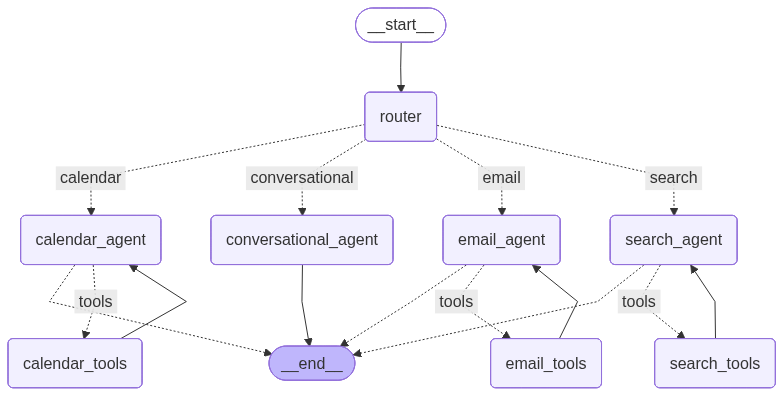

In [162]:
workflow = StateGraph(AgentState)

workflow.add_node("router", router_node)
workflow.add_node("calendar_agent", calendar_agent_node)
workflow.add_node("calendar_tools", calendar_tool_node)
workflow.add_node("email_agent", email_agent_node)
workflow.add_node("email_tools", email_tool_node)
workflow.add_node("search_agent", search_agent_node)
workflow.add_node("search_tools", search_tool_node)
workflow.add_node("conversational_agent", conversational_node)

workflow.set_entry_point("router")

workflow.add_conditional_edges(
    "router",
    lambda state: state["route"],
    {
        "calendar": "calendar_agent",
        "email": "email_agent",
        "search": "search_agent",
        "conversational": "conversational_agent"
    }
)

workflow.add_edge("conversational_agent", END)


workflow.add_conditional_edges("calendar_agent", should_call_tools, {"tools": "calendar_tools", END: END})
workflow.add_edge("calendar_tools", "calendar_agent")

workflow.add_conditional_edges("email_agent", should_call_tools, {"tools": "email_tools", END: END})
workflow.add_edge("email_tools", "email_agent")

workflow.add_conditional_edges("search_agent", should_call_tools, {"tools": "search_tools", END: END})
workflow.add_edge("search_tools", "search_agent")

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
db_path = os.path.abspath("conversations.sqlite")

print(f"Using database at: {db_path}")

with SqliteSaver.from_conn_string(db_path) as memory:
    
    app = workflow.compile(checkpointer=memory)
    print("\nRouter-based graph compiled. Ready for interaction.")
    
    config = {"configurable": {"thread_id": "berky_alkn25"}}
    print("\nYour persistent assistant is ready. You can now start chatting.")
    print("Type 'quit' or 'exit' to end the conversation.")
    print("-" * 50)
    
    while True:
        try:
            user_input = input("You: ")
            if user_input.lower() in ["quit", "exit"]:
                print("Assistant: Goodbye!")
                break

            print(f"You: {user_input}")
            
            messages = [HumanMessage(content=user_input)]
            
            response = app.invoke({"messages": messages}, config)
            
            final_response = response["messages"][-1]
            if final_response.content:
                 print(f"Assistant: {final_response.content}")
            
        except Exception as e:
            print(f"\n--- An Error Occurred ---")
            print(f"Error: {e}")
            print("Please try again.")
